# PCA in Two Different Flavors: Eigendecomposition of the Covariance Matrix and Singular Value Decomposition

### Eshed Margalit
#### Stanford University, July 2017

There are a couple of ways to perform PCA. The easier way, conceptually, is to find the eigenvectors of the covariance matrix of one's data set. However, in cases where the data matrix has many more features than samples, the covariance matrix may not be singular, and thus, may not be invertible. Even worse, the covariance matrix may be expensive to compute. This constraint will feature more prominently as dataset continue to balloon in size (#bigdata, am I right?).

The goal of this notebook is to work through some ideas in two related methods for identifying principal components of a dataset: eigenvector decomposition and singular value decomposition.

# Method 1: How do we do PCA the covariance way?

Let $\mathbf{X}$ be our data matrix, where the rows are samples (different measurements), and the columns are features (or dimensions) of each measurement. For instance, in an fMRI experiment, each row could be a measurement timepoint (a TR), and each column could be the % BOLD Signal Change within each voxel. Let $m$ be the number of measurements, and $n$ be the number of voxels we measure. Accordingly,

$$\mathbf{X} \in \mathbb{R}^{m x n} $$

If you're unfamiliar with this notation, it just means that $\mathbf{X}$ has $m$ rows and $n$ columns, and that all of its elements are real numbers (a safe assumption for most measurements).


The covariance matrix of $\mathbf{X}$ is given by 

$$\mathbf{C} = \frac{\mathbf{X^TX}}{n-1} $$

with $\mathbf{C} \in \mathbb{R}^{n x n}$

A handful of notes before we continue:
1. If your data are instead in the format $\mathbf{X} \in \mathbb{R}^{n x m}$, meaning rows are features and columns are samples, the covariance matrix is computed as $\mathbf{C} = \frac{\mathbf{XX^T}}{n-1}$. This is indeed the case in the [Shlens PCA paper](https://arxiv.org/abs/1404.1100).
1. The interpretation of the covariance matrix $\mathbf{C}$ is as follows: $\mathbf{C_{i,j}}$ is the covariance between all samples for feature $i$ and all samples for feature $j$. The diagonal entries represent the absolute covariance of a given feature. In the toy fMRI example, $\mathbf{C_{i,j}}$ is the covariance between the timeseries of voxel $i$ and the timeseries of voxel $j$.
1. The covariance matrix is symmetric, so $\mathbf{C_{i,j}} = \mathbf{C_{j,i}}$

The principal directions of $\mathbf{X}$ are given by the eigenvectors of $\mathbf{C}$. Finding eigenvectors by hand is annoying, so let's do this in MATLAB using the function $eig()$ for our toy fMRI example.

### A simple visualization (If you have a good intuition for PCA already, feel free to skip this part)

Lets look at a simple case to build intuition. This case will be in **3-D**. $\mathbf{X}$ is still our data matrix. I have collected a data set, or rather made one in the next cell. 


In [58]:
m = 20; % number of samples
n = 3; % number of features
data_span = [30, 160, 10];

X = zeros(20,3); % data matrix

for column = 1:n;
    X(:,column) = randi([-data_span(column),data_span(column)],1,m);
end

Now that we have some data lets take a look at it.

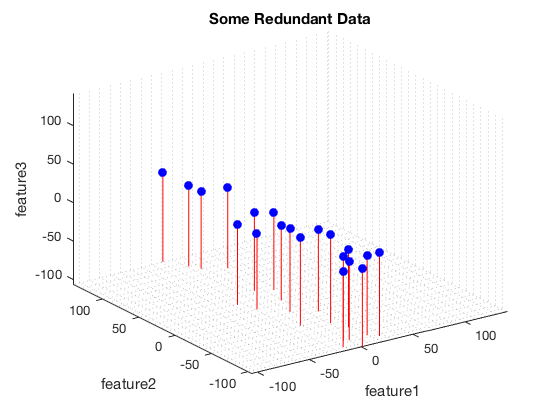

In [92]:
[fh,axh] = Plot3Data(X); 
xlabel(axh, 'feature1')
ylabel(axh, 'feature2')
zlabel(axh, 'feature3')
title('Some Redundant Data')
%view(axh,[horz_rotation_deg, virtical_elevation_deg]); % can be used to play around with axes perspective

Remember, our goal in PCA is to find a new 'basis' for $\mathbf{X}$ such that 

$$\mathbf{Y} = \mathbf{PX} $$ 

where $\mathbf{Y}$ has features with no covariance (or 'shared variance'). This means that $\mathbf{C_Y}$ would look like

   $$\mathbf{C_Y} =
          \left[ {\begin{array}{cccc}
           var_{1,1} & 0 & 0 \\
           0 & var_{2,2} & 0 \\
           0 & 0 & var_{3,3} \\
      \end{array} } \right] $$
      
Lets make our covariance matrix
$$\mathbf{C_X} = \frac{\mathbf{X^TX}}{n-1}$$

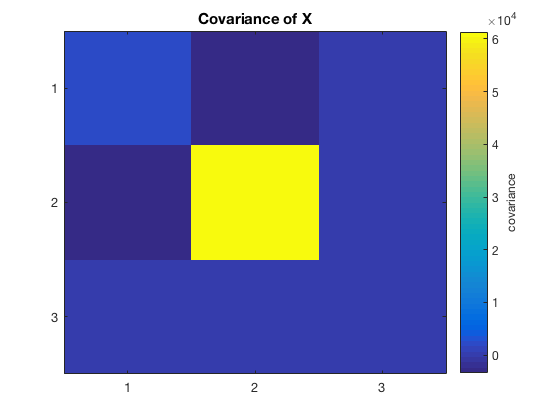

In [88]:
Cx = (X'*X)/(n-1);
figure()
ax = axes();
imagesc(ax,Cx);
c = colorbar();
ylabel(c,'covariance')
ax.XTick = [1:n];
ax.YTick = [1:n];
title('Covariance of X')

matlab

In [91]:
[P,L] = eig(Cx); % matlab can find the eigen-vectors and -values for us. (L is diagaonal matrix of lambdas)b

Lets break $\mathbf{P}$ and $\mathbf{L}$ down. 


$\mathbf{L}$ is a diagonal matrix containing our eigenvalues. 
$$\mathbf{L} =
          \left[ {\begin{array}{cccc}
           \lambda_1 & 0 & 0 \\
           0 & \lambda_2 & 0 \\
           0 & 0 & \lambda_3 \\
      \end{array} } \right] $$
      
Each column of $\mathbf{P}$ or $\mathbf{p_i}$ is an eigenvector of $\mathbf{C_X}$.

A less 'jargony' way to think about this is that when you multiply $\mathbf{C_x}$ by one of these $\mathbf{p_i}$ (choose your favorite word: principle components, eigenvectors of $\mathbf{X}$, or rows of $\mathbf{P}$) what you get out is a scaled $\mathbf{p_i}$ or $\mathbf{k*p_i}$, but it does not change direction. Commonly this scalar is reffered to as a eigenvalue and given the symbol 'lambda' ($\lambda$).
$$\mathbf{C_Xp_i} = \mathbf{\lambda}\mathbf{p_i}$$

So then if we stack all these $\mathbf{p_i}$s in columns we get $\mathbf{P}$
$$\mathbf{C_XP} = \mathbf{Y}$$

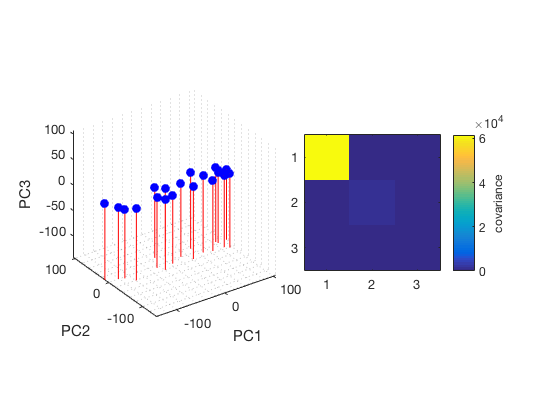

In [85]:
var_explained = diag(L);
[~,sorted_indices] = sort(var_explained, 'descend');
P_sorted = P(:, sorted_indices);
Y = X*P_sorted;

% data 'applied' to the principle components
[fh,axh] = Plot3Data(Y);
xlabel(axh, 'PC1');
ylabel(axh, 'PC2');
zlabel(axh, 'PC3');
axis square

% Covariance of Y
axh2 = subplot(1,4,[3,4]);
imagesc(axh2,Cy)
axh2.XTick = [1:n];
axh2.YTick = [1:n];
axis square
c = colorbar();
ylabel(c,'covariance')

Now if we take $\mathbf{C_Y}$ what will we have, but the variance of $\mathbf{X}$ along the principle components. 

In [ ]:
Cy = (Y'*Y)/(n-1);

### Making fake fMRI data (feel free to skip this part)

I'm going to make fake fMRI data by generating a random event train (impulse responses) and convolving with a double-gamma function that's supposed to look something like a hemodynamic response function (HRF).

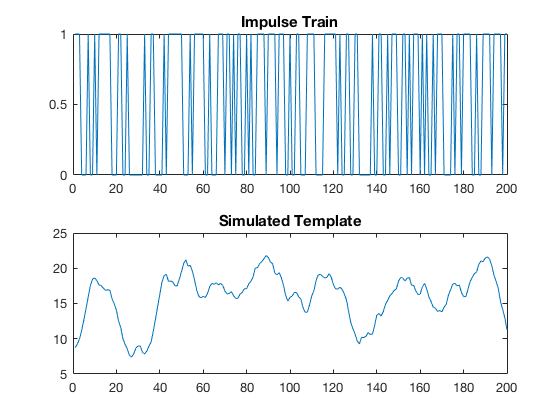

In [193]:
m = 200; % number of timepoints
n = 30; % number of voxels


hrf_x = 0:20;
HRF = hrf_x .* exp(-hrf_x/6) - 2 * hrf_x .* exp(-hrf_x/.4);

impulse_train = randi([0,1],m,1);

template = conv(impulse_train, HRF,'same');

figure();
subplot(2,1,1);
plot(1:m,impulse_train);
title('Impulse Train');
subplot(2,1,2);
plot(1:m,template);
title('Simulated Template');

Let's now formulate our data matrix as follows:

Each row of $\mathbf{X}$ is a timepoint, and each column is a noisy version of the simulated template above.
The amount of noise added is controlled by $noise\_scaling$

Finally, we center $\mathbf{X}$ (subtract the mean value of each voxel across time).

In [194]:
noise_scaling = 10;

X = zeros(m,n);

% generate a timeseries for each voxel that is some noisy version of the template
for voxel_number = 1:n
    X(:,voxel_number) = template + rand([m,1]).*noise_scaling;
end

% substract off the mean of each voxel
voxel_means = mean(X,1);
X = X - repmat(voxel_means, [m,1]); % repmat tiles the voxel_means across all of the rows (one per timepoint)


### You can check back in here if you skipped the fake data part
$\mathbf{X}$ is now ready! Let's take a look at it:

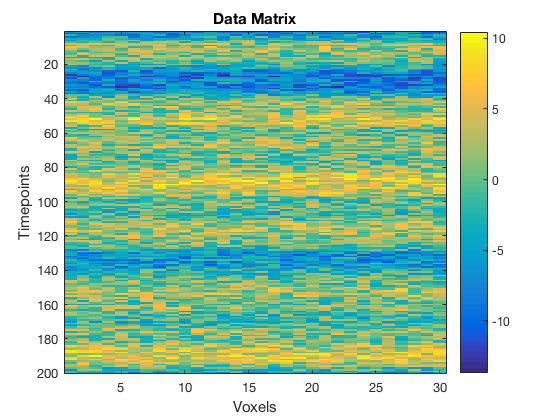

In [195]:
figure();
imagesc(X);
xlabel('Voxels');
ylabel('Timepoints');
title('Data Matrix');
colorbar();

Here's a different look at the data.

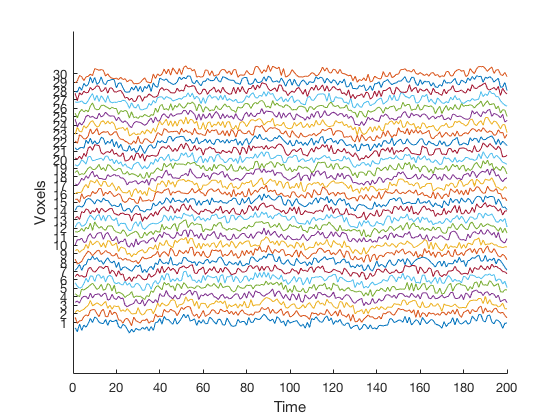

In [196]:
figure();
hold on;

for voxel_number = 1:n
    voxel_timeseries = X(:, voxel_number);
    plot(1:m, voxel_timeseries + voxel_number*noise_scaling);
end

xlabel('Time');
ylabel('Voxels');
yticks(linspace(noise_scaling,noise_scaling*n,n));
yticklabels(1:n);

Construct the covariance matrix $\mathbf{C}$. Recall that $\mathbf{C} = \frac{\mathbf{X^TX}}{n-1}$

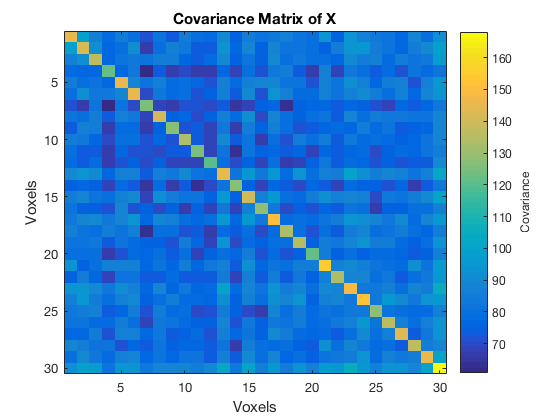

In [197]:
C = (X' * X) ./ (n-1);
figure();
imagesc(C);
xlabel('Voxels');
ylabel('Voxels');
cb = colorbar();
ylabel(cb,'Covariance');
title('Covariance Matrix of X');

So far, so good! $\mathbf{C}$ is a symmetric matrix, so we can find its eigenvectors if it is diagonalizable. That is, we can find $\mathbf{V}$ and $\mathbf{L}$, where $\mathbf{V}$ is a matrix of eigenvectors of $\mathbf{C}$ (one per column) and $\mathbf{L}$ is a diagonal matrix of the eigenvalues corresponding to the eigenvectors in $\mathbf{V}$, such that

$$\mathbf{C} = \mathbf{VLV^T}$$

Note that $\mathbf{C}$ is not guaranteed to be diagonalizable, since it might not be full-rank if $n >> m$ (columns may not be pairwise indpendent). In our example, we can be confident that the covariance matrix is well conditioned, because $n < m$.

In the meantime, MATLAB does the hard work of finding eigenvectors and eigenvalues for us:

In [198]:
[V, L] = eig(C);

$\mathbf{V}$ is the matrix of eigenvectors (one per column) of $\mathbf{C}$, and $\mathbf{L}$ is a diagonal matrix with eigenvalues on the diagonal. Let's look at $\mathbf{L}$.

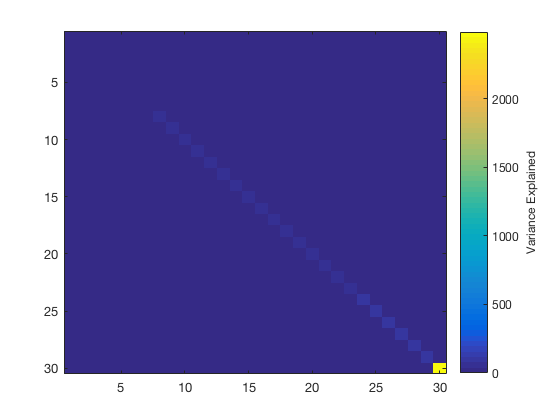

In [199]:
figure();
imagesc(L);
cb = colorbar();
ylabel(cb, 'Variance Explained');

Most of the time, MATLAB returns the eigenvectors and values sorted in ascending order (notice that the last principal direction has the highest eigenvalue in the image above). However, this sorting is not guaranteed, and we want things sorted from highest to lowest (descending order) anyway. So let's sort $\mathbf{V}$ and $\mathbf{L}$ in order of decreasing variance explained.

In [221]:
var_explained = diag(L);
[var_explained, sort_indices] = sort(var_explained,'descend');
V = V(:,sort_indices);

Finally, we can project the data onto a subset of our principal directions. These projections are our principal components (PCs). A principal component is just that: the part of our data that gets projected onto a vector representing a principal direction.

In [222]:
projection = X * V(:,1:2);

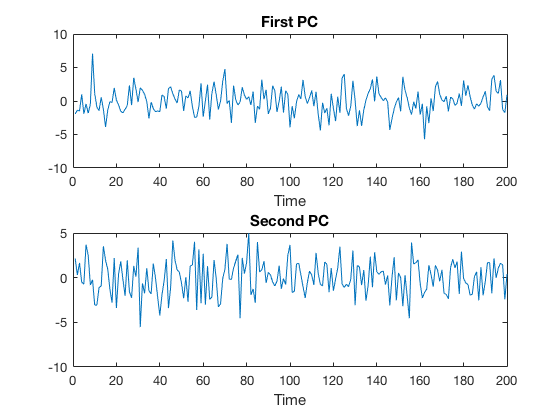

In [223]:
figure();
subplot(211);
plot(projection(:,1));
title('First PC');
xlabel('Time');

subplot(212);
plot(projection(:,2));
title('Second PC');
xlabel('Time');

# Option 2: The SVD Way

Part of the problem with the method above is that the covariance matrix is not always invertible. Another problem is that, practically speaking, the computation of the covariance matrix can be very time-consuming and expensive. Imagine, for example, computing $\mathbf{C}$ for an $\mathbf{X}$ with millions of rows and thousands of columns.

Singular Value Decomposition, or SVD, provides an alternative which can be computationally efficient and robust to rank-deficiency in the covariance matrix. In fact, many implementations of PCA use SVD under the hood (if you don't believe me, see the help page for PCA in MATLAB).

In [11]:
%type 'help pca' to see the documentation for MATLAB's PCA function

Okay, so what is SVD?

SVD decomposes any matrix $\mathbf{X} \in \mathbb{R}^{m x n}$ into three related matrices.

$$\mathbf{X} = \mathbf{USV^T}$$

where $\mathbf{U}$ contains eigenvectors of $\mathbf{XX^T}$, $\mathbf{S}$ is a diagonal matrix with the square root of the eigenvalues on its diagonal, and $\mathbf{V^T}$ contains eigenvectors of $\mathbf{X^TX}$. 

Note a few of odd things:
1. Because of the way $\mathbf{U}$ is formed, it is an $(m x m)$ matrix.
1. Because of the way $\mathbf{V^T}$ is formed, it is an $(n x n)$ matrix.
1. Both $\mathbf{U}$ and $\mathbf{V}$ are orthonormal.


### A more intuitive understanding of what SVD does

SVD can be thought of as an iterative approach to finding the best possible subspace for a dataset. Consider the fMRI example above. Each timepoint can be conceptualized as a point in 30-dimensional space, one dimension per voxel. However, our data are rank-deficient, and can be well-approximated by less than 30 dimensions. How do we find those dimensions? The SVD approach is to start by finding the line which passes through the origin that best fits the timepoints in 30-D space. This is equivalent to identifying the vector which has the greatest sum of projections of data points onto it. SVD then finds another line, orthogonal to the first, that aims to maximize the same objective: get good projections of the data points onto the line. This continues until all such orthogonal vectors are identified (there can be as many as 30 in our example, and there will be 30 if $\mathbf{X}$ is full-rank). 

These vectors are the columns of $\mathbf{V}$ above, and they are also the eigenvectors of $\mathbf{X^TX}$, and thus, they are our principal directions!
The columns of $\mathbf{U}$ are related to the columns of $\mathbf{V}$. Formally,

$$u_i = \frac{1}{\sigma_i}\mathbf{X}v_i$$

where $\sigma_i$ is the singular value associated with the $i$th left singular vector.

### Why is this decomposition helpful?
Jonathon Shlens explains the function of SVD well in his article, [A Tutorial on Independent Component Analysis](https://arxiv.org/abs/1404.2986). He notes that SVD simply decomposes the role of a matrix into the three things it can do: a rotation, a stretch, and another rotation. $\mathbf{V}$ and $\mathbf{U}$ are rotation matrices, and $\mathbf{S}$ is the stretching matrix. See his diagram below, but note that he uses $\mathbf{\Sigma}$ instead of $\mathbf{S}$, and $\mathbf{A}$ instead of $\mathbf{X}$. The point he's making is that for some data matrix $\mathbf{A}$, its inverse (call it $\mathbf{W}$) can be represented by the inverse of its SVD decomposition: $\mathbf{W} = \mathbf{VS^{-1}U^T}$ (or, in his notation: $\mathbf{W} = \mathbf{V\Sigma^{-1}U^T}$. This matrix is important for ICA, but we can file it under "fun trivia" for now.

<img src="img/shlens_figure_6.png">

*Figure 6 from [Shlens, 2014](https://arxiv.org/abs/1404.2986)*

## Relating Method 1 to SVD

I'm going to be following the logic laid out in [this Stack Overflow article](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

Recall from earlier in the notebook that

$$\mathbf{C} = \frac{\mathbf{X^TX}}{n-1}$$

and

$$\mathbf{X} = \mathbf{USV^T}$$

Thus,

$$\mathbf{C} = \frac{\mathbf{((USV^T)^T)(USV^T)}}{n-1}$$

Bringing the transpose inside, we have
$$\mathbf{C} = \frac{\mathbf{((V^T)^TS^TU^T)(USV^T)}}{n-1}$$

The double transpose on $\mathbf{V}$ cancels out, and $\mathbf{S^T} = \mathbf{S}$ because it is diagonal. We can then simplify to

$$\mathbf{C} = \frac{\mathbf{(VSU^T)(USV^T)}}{n-1}$$

*An aside: $\mathbf{U^TU}$ is the identity matrix. Why?*
Because $\mathbf{U}$ is orthonormal, its transpose is also its inverse. So $\mathbf{U^TU} = \mathbf{U^{-1}U} = \mathbf{I}$.

Continuing to simplify, 

$$\mathbf{C} = \frac{\mathbf{VSISV^T}}{n-1}$$

We can drop the identity matrix and combine the $\mathbf{S}$ terms to get

$$\mathbf{C} = \frac{\mathbf{VS^2V^T}}{n-1}$$

Starting to look familiar? One more thing: let's rearrange terms like this:

$$\mathbf{C} = \mathbf{V}\frac{\mathbf{S^2}}{n-1}\mathbf{V^T}$$

### Where are we going with this?

Let's compare two different formulations of $\mathbf{C}$ that we've gotten so far.

The first is from the eigenvalue decomposition approach, where we just found the eigenvectors of $\mathbf{C}$.

$$\mathbf{C} = \mathbf{VLV^T}$$

The second is from the SVD approach.

$$\mathbf{C} = \mathbf{V}\frac{\mathbf{S^2}}{n-1}\mathbf{V^T}$$

We can see that $\mathbf{L}$ and $\frac{\mathbf{S^2}}{n-1}$ are equivalent. What does that mean?

Simply, it means that the singular values in $\mathbf{S}$ are related to the eigenvalues in $\mathbf{L}$ such that the singular values are the normalized square roots of the eigenvalues. Cool!

## Let's do SVD!
Recall that $\mathbf{X}$ is our centered data. We're first going to construct a normalized version of $\mathbf{X}$, which we'll call $\mathbf{Y}$. The normalization helps keeps quantities interpretable, see the Shlens paper for details. Effectively this will deal with the need to divide by $n-1$ when converting from singular values to eigenvalues.

Recall the following from earlier in the notebook:
1. After SVD, $\mathbf{X} = \mathbf{USV^T}$
2. $\mathbf{V}$ contains the eigenvectors of the covariance matrix

Following from (1), we see that $\mathbf{XV} = \mathbf{US}$. Following from (2) and recalling the projection we constructed using eigendecomposition, we see that $\mathbf{XV}$ is equivalent to projecting the data onto our principal directions. 

To confirm this equivalence, I'll compute the first PC using both formulations below and compare them to the first PC we derived the eigendecomposition way.

In [12]:
Y = X ./ sqrt(n-1);

[U,S,V] = svd(Y);

variances = diag(S) .* diag(S); % singular values need to squared, see explanation above.


projection1 = U * S(:,1:2); % first method: PCs via US
projection2 = X * V(:,1:2); % second method: PCs via XV


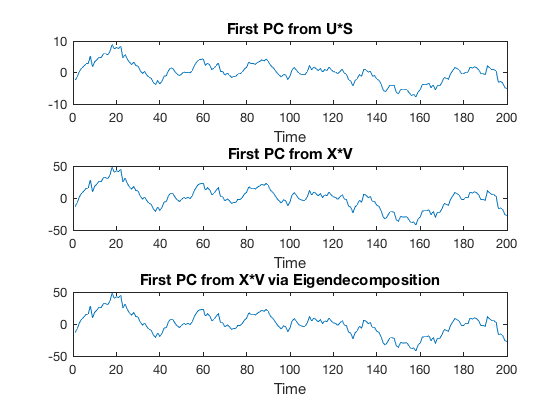

In [13]:
figure();
subplot(311);
plot(projection1(:,1));
title('First PC from U*S');
xlabel('Time');

subplot(312);
plot(projection2(:,1));
title('First PC from X*V');
xlabel('Time');

subplot(313);
plot(projection(:,1));
title('First PC from X*V via Eigendecomposition');
xlabel('Time');